# Importation des librairies

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from munkres import Munkres
from model import CNNModel, ResNet
import seaborn as sns
import torch.nn as nn
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import pickle
import torch
import tqdm
import ray

## Définition du modèle

In [2]:
MATRIX_SIZE = 12

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

"""
model = CNNModel(
    state_size=MATRIX_SIZE**2,
    input_size=2,
    num_hidden=64
).to(device)
"""

model = ResNet(
    state_size=MATRIX_SIZE**2,
    input_size=2,
    num_resBlocks=4,
    num_hidden=64
).to(device)

## Fonction pour augmenter la taille de la matrice

In [3]:
def augmented_matrix(matrix: np.ndarray, new_size: int, g1: nx.Graph, g2: nx.Graph) -> np.ndarray:
    if matrix.shape[0] > new_size or matrix.shape[1] > new_size:
        raise ValueError("New size is smaller than the original matrix")
    n = len(g1.nodes)
    m = len(g2.nodes)
    new_matrix = np.zeros((new_size, new_size))
    new_matrix[:matrix.shape[0], :matrix.shape[1]] = matrix
    for i in range(new_size):
        for j in range(new_size):
            if i < n and j >= matrix.shape[0]:
                to_replace = matrix[i, -1]
                new_matrix[i, j] = to_replace
            elif i >= matrix.shape[1] and j < m:
                to_replace = matrix[-1, j]
                new_matrix[i, j] = to_replace

    return new_matrix


## Chargement des données

Taille du dataset : 99681


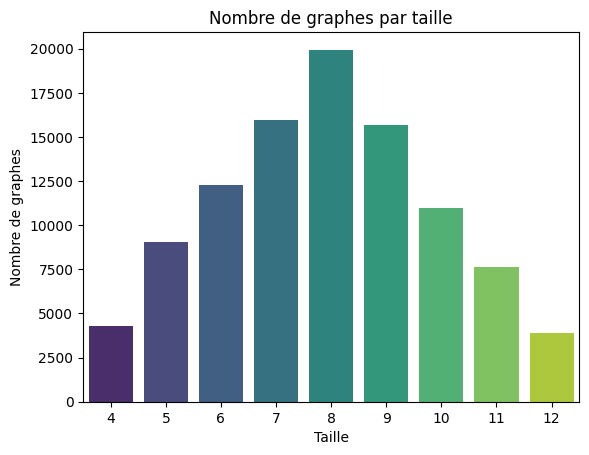

In [41]:
dataset_name = "447_graphs.pkl"

with open(f"processed/{dataset_name}", "rb") as file:
    data = pickle.load(file)

print(f"Taille du dataset : {len(data)}")

matrix = data.loc[1, "cost_matrix"]
g1 = data.loc[1, "g1"]
g2 = data.loc[1, "g2"]

sizes = {}
for i in range(len(data)):
    size = data.loc[i, "cost_matrix"].shape[0]
    if size not in sizes:
        sizes[size] = 1
    else:
        sizes[size] += 1

fig, ax = plt.subplots()
sns.set_style()
sns.barplot(x=np.array(list(sizes.keys())), y=np.array(list(sizes.values())), ax=ax, palette="viridis")
ax.set_title("Nombre de graphes par taille")
ax.set_xlabel("Taille")
ax.set_ylabel("Nombre de graphes")
plt.show()


## Génération des données pour le modèle à partir de la base de données

In [15]:
def process_matrix(matrix: np.ndarray, size: int) -> np.ndarray:
    """Process the matrix to be used as input for the model."""
    matrix = matrix.astype(np.float32)
    for i in range(size):
        total_value = matrix[i].sum()
        probs = [abs((value - total_value) ** 2) for value in matrix[i]]
        normalized_probs = [prob / sum(probs) for prob in probs]
        matrix[i] = np.round(normalized_probs, 2)
    return matrix


def solve_matrix(matrix: np.ndarray) -> np.ndarray:
    """Solve the matrix with the Hungarian algorithm."""
    m = Munkres()
    indexes = m.compute(matrix.copy().tolist())
    solution = np.zeros(matrix.shape)
    for row, column in indexes:
        solution[row][column] = 1
    return solution


def get_solutions(matrix: np.ndarray, solution: np.ndarray, size: int) -> tuple[list[np.ndarray], list[float]]:
    """Get all sub-solutions of a solution."""
    valid_solutions = [solution]
    valid_solutions_sum = [round(np.multiply(matrix, solution).sum(), 2)]
    # Remove successively the last one by row
    for k in range(size - 1):
        line = size - k - 1
        indexes = np.argwhere(valid_solutions[-1][line] == 1).flatten()
        if len(indexes) > 0:
            new_solution = valid_solutions[-1].copy()
            new_solution[line][indexes[0]] = 0
            valid_solutions.append(new_solution)
            valid_solutions_sum.append(
                round(np.multiply(matrix, new_solution).sum(), 2))
    return valid_solutions, valid_solutions_sum


def get_random_solution(size: int) -> np.ndarray:
    """Get a random solution."""
    random_permutation = np.random.permutation(size)
    solution = np.zeros((size, size))
    for k in range(size):
        solution[k][random_permutation[k]] = 1
    return solution


def generate_datas(datas: pd.DataFrame, size: int) -> tuple[np.ndarray, np.ndarray]:
    """Return processed data for the model"""
    states = []
    values = []

    for i in tqdm.tqdm(range(len(datas))):
        # Create a random process matrix
        random_matrix = np.array(datas.loc[i, "cost_matrix"])
        if random_matrix.shape[0] != size:
            random_matrix = augmented_matrix(
                random_matrix, size, datas.loc[i, "g1"], datas.loc[i, "g2"]
            )

        # Solve the problem with the Hungarian algorithm
        valide_solution = solve_matrix(random_matrix)

        # Get all sub-solutions of the valid solution and add them to the dataset
        valid_solutions, _ = get_solutions(
            random_matrix, valide_solution, size
        )

        for valid_solution in valid_solutions:
            state = np.stack([random_matrix, valid_solution], axis=0)
            states.append(torch.tensor(state, dtype=torch.float32))
            values.append(1)

        # Create a random solution
        solution = get_random_solution(size)

        # Get all sub-solutions of the random solution and add them to the dataset
        random_solutions, _ = get_solutions(random_matrix, solution, size)

        for (random_solution, valid_solution) in zip(random_solutions, valid_solutions):
            state = np.stack([random_matrix, random_solution], axis=0)
            states.append(torch.tensor(state, dtype=torch.float32))
            values.append(1 if np.array_equal(
                random_solution, valid_solution) else 0)

    return np.stack(states, axis=0), np.array(values)

In [31]:
sizes = {}
for i in range(len(data)):
    size = data.loc[i, "cost_matrix"].shape[0]
    if size not in sizes:
        sizes[size] = 1
    else:
        sizes[size] += 1

sizes = list(sizes.keys())
sizes = [MATRIX_SIZE]

model_data = {
    size: generate_datas(data, size) for size in sizes
}

test_percentage = 0.1
test_size = int(test_percentage * len(model_data[MATRIX_SIZE][0]))
print(f"Taille du dataset : {len(model_data[MATRIX_SIZE][0])}")
print(f"Taille du dataset de test : {test_size}")

train_states = model_data[MATRIX_SIZE][0][:-test_size]
train_values = model_data[MATRIX_SIZE][1][:-test_size]

test_states = model_data[MATRIX_SIZE][0][-test_size:]
test_values = model_data[MATRIX_SIZE][1][-test_size:]

dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_states, dtype=torch.float32),
    torch.tensor(train_values, dtype=torch.float32)
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 99681/99681 [02:28<00:00, 670.13it/s]


Taille du dataset : 2392344
Taille du dataset de test : 239234


## Entrainement du modèle

In [43]:
# Create a loss function and an optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    running_loss = 0
    for states, values in dataloader:
        optimizer.zero_grad()
        states = states.to(device)
        outputs = model(states)
        values = values.unsqueeze(1)
        values = torch.cat([1 - values, values], dim=1)
        values = values.to(device)
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch + 1) % 1 == 0:
        print(
            f"-----Epoch {epoch + 1}, loss: {running_loss / len(dataloader) * 10:.2f}-----"
        )

        # Test the model
        random_index = [np.random.randint(0, len(test_states)) for _ in range(100)]
        random_test_states = test_states[random_index]
        random_test_values = test_values[random_index]
        random_test_states = torch.tensor(random_test_states, dtype=torch.float32)
        random_test_values = torch.tensor(random_test_values, dtype=torch.float32)
        random_test_states = random_test_states.to(device)
        random_test_values = random_test_values.to(device)
        random_outputs = model(random_test_states)
        random_values = random_test_values.unsqueeze(1)
        random_values = torch.cat([1 - random_values, random_values], dim=1)
        random_loss = criterion(random_outputs, random_values)
        print(f"Test loss: {random_loss.item() * 100:.2f}%")

-----Epoch 1, loss: 0.11-----
Test loss: 0.93%
-----Epoch 2, loss: 0.06-----
Test loss: 0.71%
-----Epoch 3, loss: 0.05-----
Test loss: 0.04%
-----Epoch 4, loss: 0.04-----
Test loss: 0.07%
-----Epoch 5, loss: 0.04-----
Test loss: 0.05%
-----Epoch 6, loss: 0.03-----
Test loss: 2.01%
-----Epoch 7, loss: 0.03-----
Test loss: 0.01%
-----Epoch 8, loss: 0.03-----
Test loss: 1.01%
-----Epoch 9, loss: 0.03-----
Test loss: 0.01%
-----Epoch 10, loss: 0.02-----
Test loss: 0.02%


## Evaluation du modèle

(239234, 2, 12, 12)
{0: [1, 13, 25, 37, 49, 61, 73, 85, 97, 109, 121, 133, 145, 157, 169, 181, 193, 205, 217, 229, 241, 253, 265, 277, 289, 301, 313, 325, 337, 349, 361, 373, 385, 397, 409, 421, 433, 445, 457, 469, 481, 493, 505, 517, 529, 541, 553, 565, 577, 589, 601, 613, 625, 637, 649, 661, 673, 685, 697, 709, 721, 733, 745, 757, 769, 781, 793, 805, 817, 829, 841, 853, 865, 877, 889, 901, 913, 925, 937, 949, 961, 973, 985, 997, 1009, 1021, 1033, 1045, 1057, 1069, 1081, 1093, 1105, 1117, 1129, 1141, 1153, 1165, 1177, 1189, 1201, 1213, 1225, 1237, 1249, 1261, 1273, 1285, 1297, 1309, 1321, 1333, 1345, 1357, 1369, 1381, 1393, 1405, 1417, 1429, 1441, 1453, 1465, 1477, 1489, 1501, 1513, 1525, 1537, 1549, 1561, 1573, 1585, 1597, 1609, 1621, 1633, 1645, 1657, 1669, 1681, 1693, 1705, 1717, 1729, 1741, 1753, 1765, 1777, 1789, 1801, 1813, 1825, 1837, 1849, 1861, 1873, 1885, 1897, 1909, 1921, 1933, 1945, 1957, 1969, 1981, 1993, 2005, 2017, 2029, 2041, 2053, 2065, 2077, 2089, 2101, 2113, 2125, 2

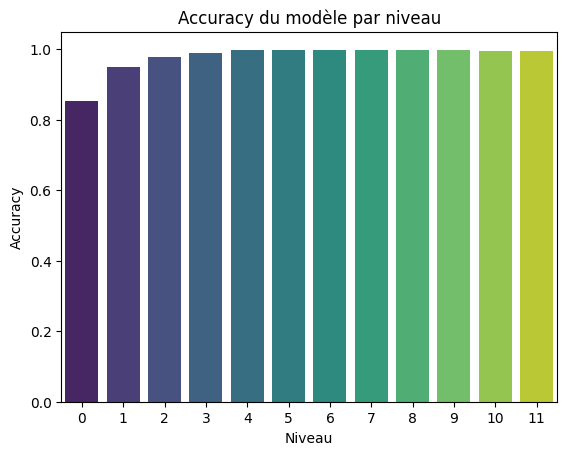

In [44]:
test_states = model_data[MATRIX_SIZE][0][-test_size:]
test_values = model_data[MATRIX_SIZE][1][-test_size:]

def get_matrix_level(matrix: np.ndarray) -> int:
    """Return the index of the last row with a 1"""
    return next(
        (i - 1 for i in range(matrix.shape[0]) if matrix[i].sum() != 1),
        matrix.shape[0] - 1
    )

level_matrix = {
    level: [] for level in range(MATRIX_SIZE)
}
print(test_states.shape)

for i in range(len(test_states)):
    level = get_matrix_level(test_states[i][1])
    level_matrix[level].append(i)

min_level = min(len(level_matrix[level]) for level in level_matrix)
max_level = max(len(level_matrix[level]) for level in level_matrix)

print(level_matrix)
print(
    f"Sample size: [{min_level}, {max_level}]"
)
# show model accuracy for each level
accuracies = []
for level in level_matrix:
    correct = 0
    if len(level_matrix[level]) == 0:
        accuracies.append(0)
        continue
    for i in level_matrix[level]:
        outputs = model(torch.tensor(
            test_states[i].reshape(1, 2, MATRIX_SIZE, MATRIX_SIZE), dtype=torch.float32).to(device))
        if torch.argmax(outputs).item() == test_values[i]:
            correct += 1
    accuracies.append(correct / len(level_matrix[level]))

fig, ax = plt.subplots()
sns.set_style()
sns.barplot(x=np.array(list(level_matrix.keys())),
            y=np.array(accuracies), ax=ax, palette="viridis")
ax.set_title("Accuracy du modèle par niveau")
ax.set_xlabel("Niveau")
ax.set_ylabel("Accuracy")
plt.show()

In [45]:
import os

# save the model
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/resnet_model_12.pth")

## Test du modèle sur des graphes générés aléatoirement

In [110]:
from tools import generate_data, get_cost_matrix

data_size = 100
n = int(np.ceil((1 + np.sqrt(1 + 8 * data_size)) / 2))
print(f"Generating {n} graphs")

graphs = generate_data(n, 6, verbose=True, max_ged_size=10)
print(f"Taille du dataset : {len(graphs)}")

Generating 15 graphs


100%|██████████| 105/105 [00:00<00:00, 2031.43it/s]


Taille du dataset : 105


In [60]:
# load the model
model = CNNModel(
    state_size=MATRIX_SIZE**2,
    input_size=2,
    num_hidden=64
).to(device)

model.load_state_dict(torch.load("models/cnn_model_12.pth"))

<All keys matched successfully>

In [128]:
import random
graph_lens = len(graphs)
print(f"Taille du dataset : {graph_lens}")
total = 0
for _ in range(1000):
    cost_matrix = graphs.loc[random.randint(0, graph_lens - 1), "cost_matrix"]
    # test the model with the cost matrix
    valid_solution = solve_matrix(cost_matrix)
    valid_solution[-8:, :] = 0

    # pass through the model
    valid_solution = torch.tensor(valid_solution, dtype=torch.float32)
    tensor_cost_matrix = torch.tensor(cost_matrix, dtype=torch.float32)
    state = torch.stack([tensor_cost_matrix, valid_solution], axis=0)
    state = state.unsqueeze(0)
    state = state.to(device)
    output = model(state)

    total += np.argmax(output.cpu().detach().numpy())

print(f"total: {total/1000*100}% of accuracy")

cost_matrix = torch.tensor(cost_matrix, dtype=torch.float32)

total = 0
for _ in range(1000):
    # unvalid solution
    unvalid_solution = get_random_solution(MATRIX_SIZE)
    unvalid_solution[-1:, :] = 0

    unvalid_solution = torch.tensor(unvalid_solution, dtype=torch.float32)
    state = torch.stack([cost_matrix, unvalid_solution], axis=0)
    state = state.unsqueeze(0)
    state = state.to(device)
    output = model(state)

    total += np.argmax(output.cpu().detach().numpy())

print(f"total: {total/1000*100}% of error")



Taille du dataset : 105
total: 100.0% of accuracy
total: 0.0% of error


In [145]:
cost_matrix = graphs.loc[2, "cost_matrix"]
valid_solution = get_random_solution(MATRIX_SIZE)
valid_solution[-2:, :] = 0


for i in range(MATRIX_SIZE):
    copy_solution = valid_solution.copy()
    copy_solution[-2, i] = 1

    copy_solution = torch.tensor(copy_solution, dtype=torch.float32)
    state = torch.stack([torch.tensor(cost_matrix, dtype=torch.float32), copy_solution], axis=0)
    state = state.unsqueeze(0)
    state = state.to(device)
    output = model(state)

    print(f"i: {i}, output: {output}, argmax: {torch.argmax(output)}")




i: 0, output: tensor([[0.9834, 0.0166]], device='cuda:0', grad_fn=<AddmmBackward0>), argmax: 0
i: 1, output: tensor([[0.9834, 0.0166]], device='cuda:0', grad_fn=<AddmmBackward0>), argmax: 0
i: 2, output: tensor([[0.9834, 0.0166]], device='cuda:0', grad_fn=<AddmmBackward0>), argmax: 0
i: 3, output: tensor([[0.9830, 0.0171]], device='cuda:0', grad_fn=<AddmmBackward0>), argmax: 0
i: 4, output: tensor([[0.9834, 0.0166]], device='cuda:0', grad_fn=<AddmmBackward0>), argmax: 0
i: 5, output: tensor([[0.9834, 0.0166]], device='cuda:0', grad_fn=<AddmmBackward0>), argmax: 0
i: 6, output: tensor([[0.9834, 0.0166]], device='cuda:0', grad_fn=<AddmmBackward0>), argmax: 0
i: 7, output: tensor([[0.9791, 0.0209]], device='cuda:0', grad_fn=<AddmmBackward0>), argmax: 0
i: 8, output: tensor([[0.9840, 0.0160]], device='cuda:0', grad_fn=<AddmmBackward0>), argmax: 0
i: 9, output: tensor([[0.9831, 0.0169]], device='cuda:0', grad_fn=<AddmmBackward0>), argmax: 0
i: 10, output: tensor([[0.9844, 0.0156]], device='